# SEMPRE 50th Anniversary Conference
![Sempre Logo](https://sempre.org.uk/images/sempre50th.jpg)
## Video Figures

These figures were created for use in a video presentation for the SEMPRE 50th Anniversary Conference, Senate House, University of London, 2-3rd September 2022.

The title of the presentation was "Measuring the effects of variable latency timings and jitter on networked music performances".

## Import dependencies

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
from scipy.signal import savgol_filter

## Load processed data

In [2]:
def load_data(input_filepath):
    """Loads all pickled data from the processed data folder"""
    return [pickle.load(open(f'{input_filepath}\\{f}', "rb")) for f in os.listdir(input_filepath) if f.endswith('.p')]

In [3]:
input_filepath = "C:\Python Projects\jazz-jitter-analysis\data\processed"
figures_filepath = r"C:\Python Projects\jazz-jitter-analysis\reports\figures"
data = load_data(input_filepath)

## Subset loaded data
We only need to keep data for the performances we're using as part of the video

In [4]:
# Define variables to be assigned later
decelerating_perf_k = None
decelerating_perf_d = None
accelerating_perf_k = None
accelerating_perf_d = None

In [5]:
col = ['onset', 'pitch', 'velocity']
def format_loaded_data(arr) -> pd.DataFrame:
    """Formats loaded dataframe, generates BPMs with rolling window"""
    # Load dataframe, drop unnecessary columns
    df = pd.DataFrame(arr, columns=col).drop(['pitch', 'velocity'], axis=1)
    # Extract IOI
    df['ioi'] = df['onset'].diff()
    df['onset_floor'] = np.floor(df['onset'])
    return df

In [6]:
# Iterate through all 5 trials
for trial in data:
    
    # Iterate through each condition in trial
    for con in trial:
        
        # Decelerating performance
        if con['trial'] == 4 and con['block'] == 1 and con['latency'] == 45 and con['jitter'] == 1:
            if con['instrument'] == 'Drums':
                decelerating_perf_d = format_loaded_data(con['midi_bpm'])
            elif con['instrument'] == 'Keys':
                decelerating_perf_k = format_loaded_data(con['midi_bpm'])
        
        # Accelerating performance
        elif con['trial'] == 5 and con['block'] == 1 and con['latency'] == 180 and con['jitter'] == 1:
            if con['instrument'] == 'Drums':
                accelerating_perf_d = format_loaded_data(con['midi_bpm'])
            elif con['instrument'] == 'Keys':
                accelerating_perf_k = format_loaded_data(con['midi_bpm'])

## Average data for both instruments and roll

In [7]:
def average_perf(df1, df2) -> list:
    """
    Returns a list of averaged BPMs from two performance.
    Data is grouped by every second in a performance.
    """
    # Merge dataframes from both performers together
    bigdf = df1.merge(df2, how='inner', on='onset_floor')
    # Set function
    fn = lambda g: g.drop_duplicates().dropna().tolist()
    # Average tempo of beat onsets created by both musicians within one second
    avg_tempo = [(idx, np.mean([*fn(60/grp['ioi_x']), *fn(60/grp['ioi_y'])])) for idx, grp in bigdf.groupby('onset_floor')]
    # Create dataframe
    processed_df = pd.DataFrame(avg_tempo, columns=['onset', 'bpm_avg'])
    # Roll average BPM column
    processed_df['bpm_rolling'] = processed_df['bpm_avg'].rolling(window=4).mean()
    return processed_df

In [8]:
decelerating_df = average_perf(decelerating_perf_d, decelerating_perf_k)
accelerating_df = average_perf(accelerating_perf_d, accelerating_perf_k)

## Create graphs

In [9]:
# Set options in matplotlib
plt.style.use('seaborn-poster')
plt.rcParams.update({
    'font.size': 45,
    "font.family": "sans",
    'legend.fontsize': 'x-large',
    'figure.figsize': (30, 14),
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'lines.linewidth': 10,
    'lines.markersize': 10,
    'ytick.major.size': 30.0,
    'xtick.major.size': 30.0,
})

csfont = {'fontname': 'Calibri'}

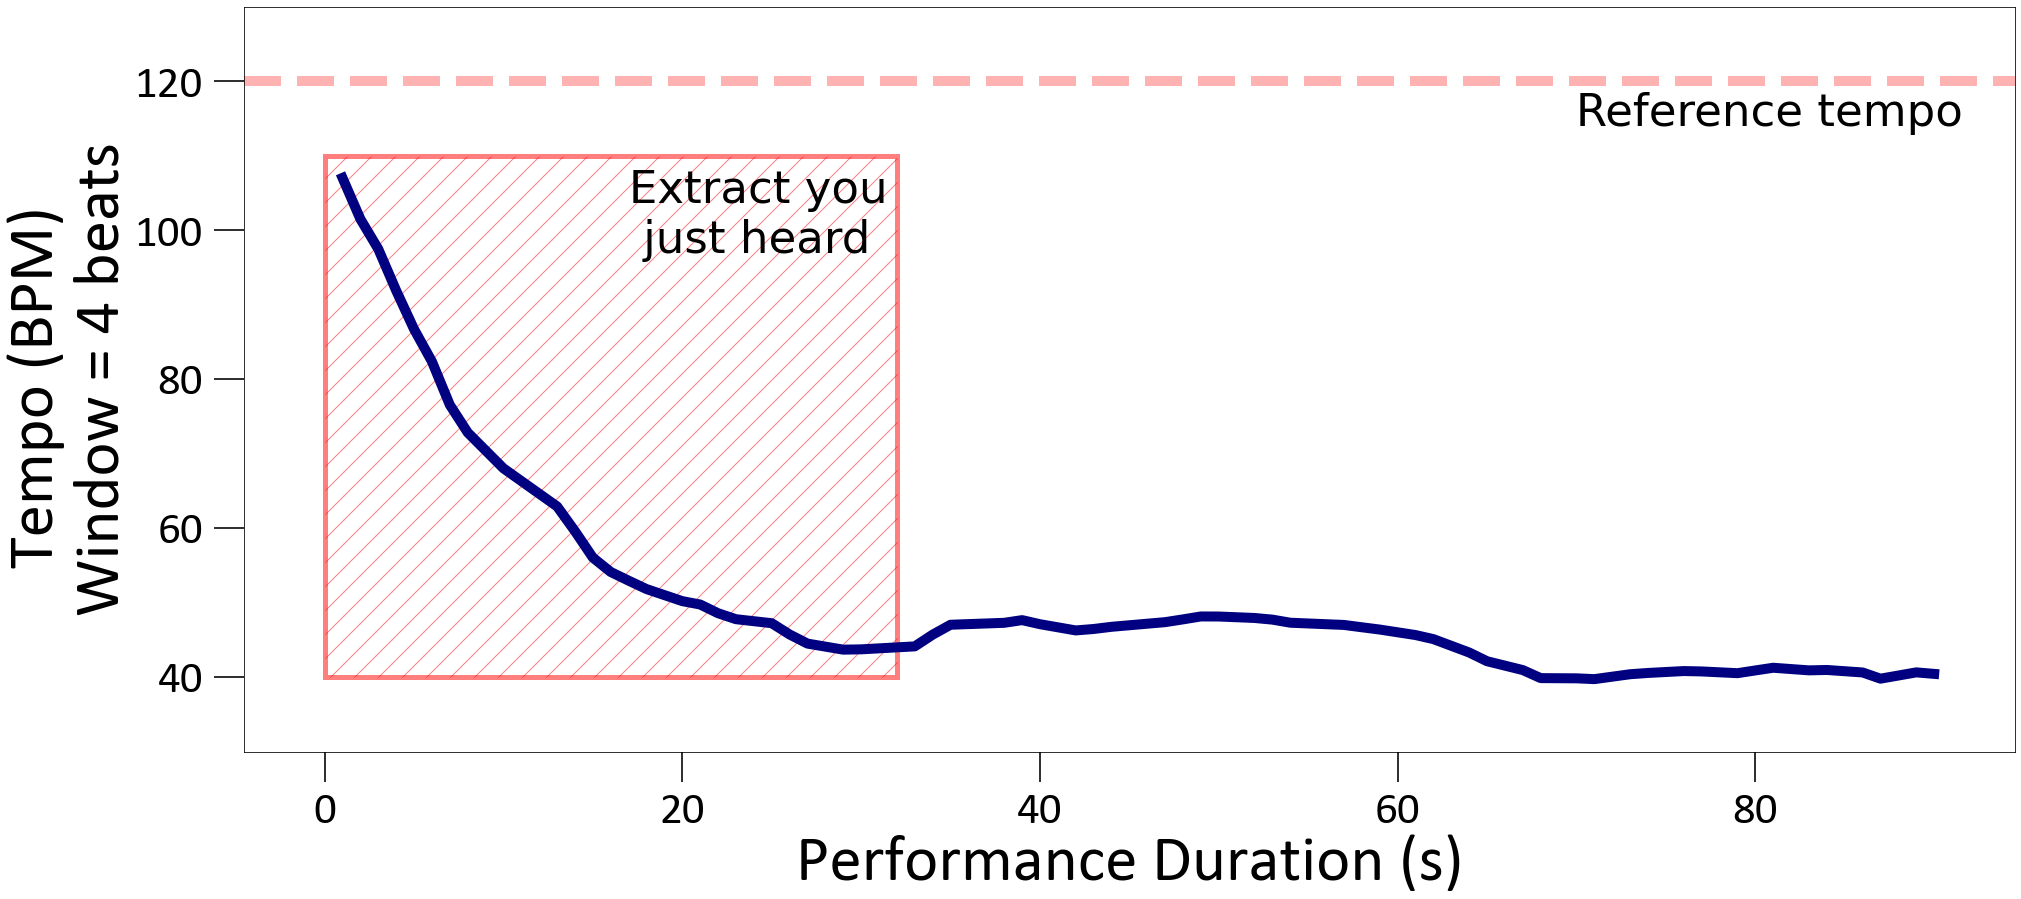

In [10]:
# Create subplots
fig, ax = plt.subplots(1, 1)
# Plot tempo graph
ax.plot(decelerating_df['onset'] - 10, decelerating_df['bpm_rolling'], color='#000080')
# Add rectangle showing excerpt
ax.add_patch(
     matplotlib.patches.Rectangle(
         (0, 40),
         height=70,
         width=32,
         fill=False,
         color='red',
         hatch='/',
         linewidth=5.0,
         capstyle='butt',
         alpha=0.5,
     )
)
# Add horizontal line showing reference tempo
ax.axhline(y=120, color='r', linestyle='--', alpha=0.3)
# Set titles, labels, axis limits
ax.set_ylabel('Tempo (BPM) \nWindow = 4 beats', **csfont)
ax.set_xlabel('Performance Duration (s)', **csfont)
ax.set_ylim((30, 130))
ax.annotate("Reference tempo", xy=(80, 120), xytext=(70, 114),)
ax.annotate("Extract you \n just heard", xy=(15, 100), xytext=(17, 97),)
plt.tight_layout()

for label in ax.get_xticklabels() :
    label.set_fontproperties('Calibri')
for label in ax.get_yticklabels() :
    label.set_fontproperties('Calibri')
plt.xticks(fontsize=45,)
plt.yticks(fontsize=45,)

fig.savefig(f'{figures_filepath}\\sempre_presentation_graphs\\sempre_graphs_decelerating_performance.png', facecolor='white', transparent=False)

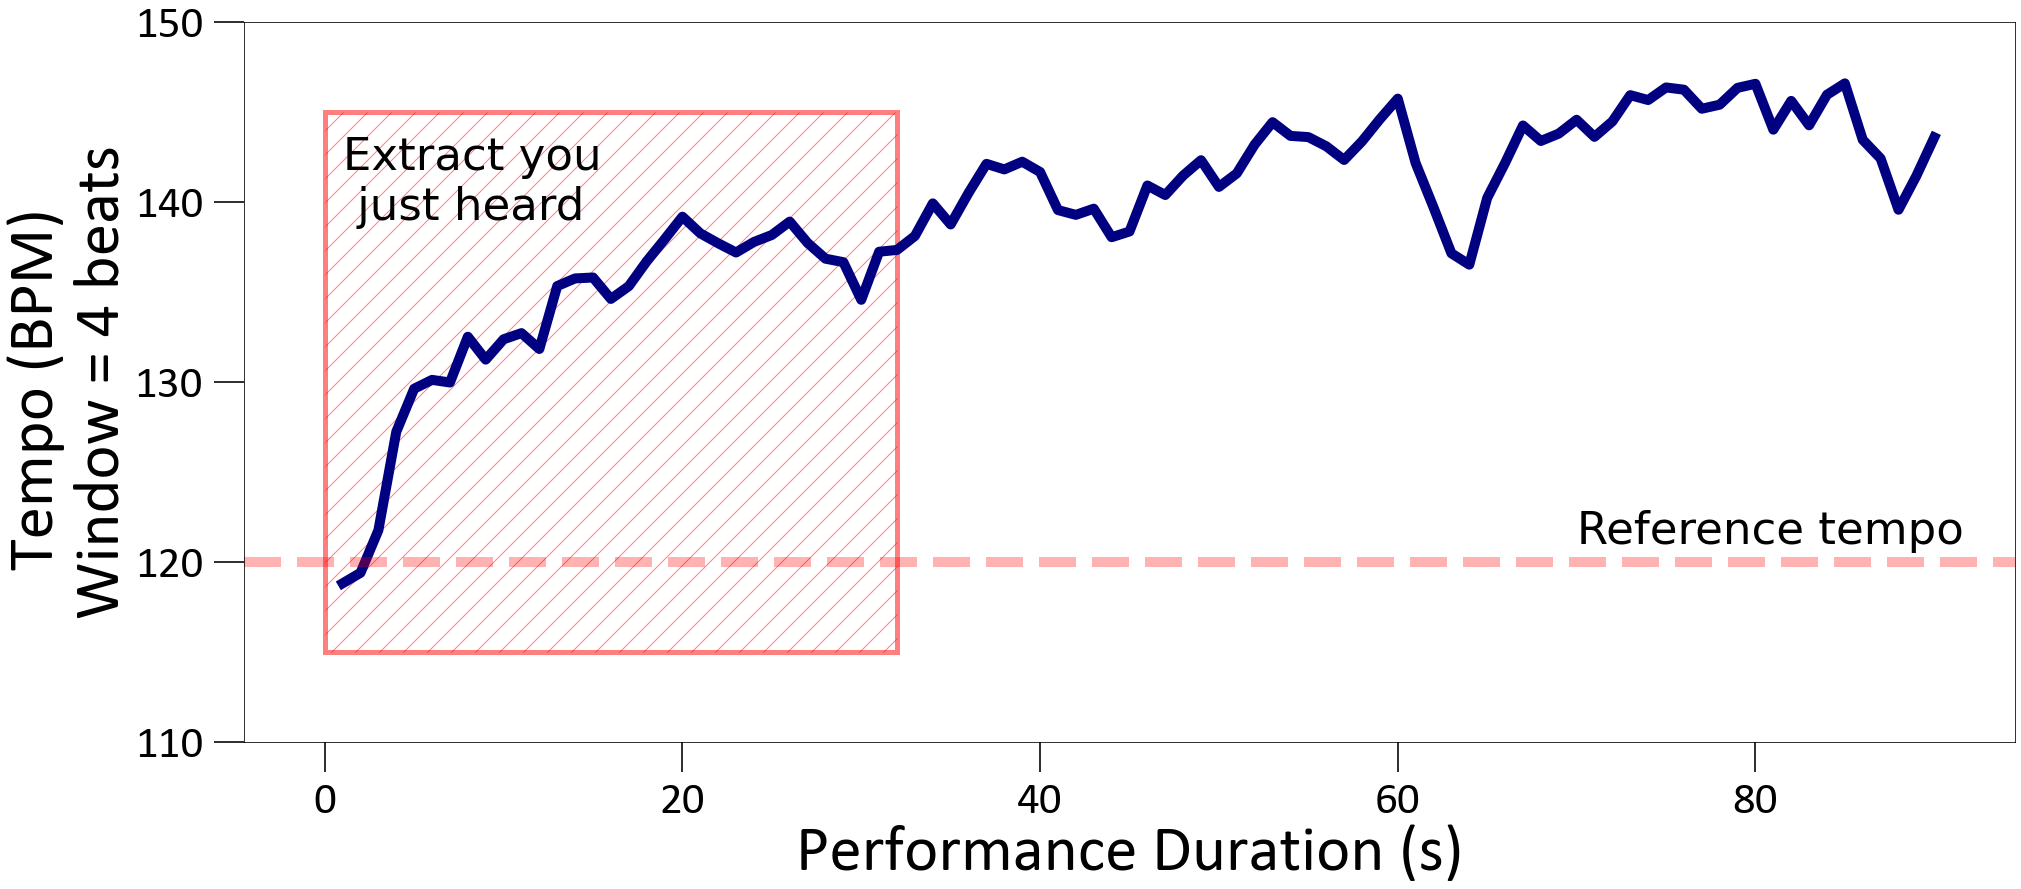

In [11]:
fig, ax = plt.subplots(1, 1)
ax.plot(accelerating_df['onset'] - 10, accelerating_df['bpm_rolling'], color='#000080')
ax.set_ylabel('Tempo (BPM) \nWindow = 4 beats', **csfont)
ax.set_xlabel('Performance Duration (s)', **csfont)
ax.set_ylim((110, 150))
ax.add_patch(
     matplotlib.patches.Rectangle(
         (0, 115),
         height=30,
         width=32,
         fill=False,
         color='red',
         hatch='/',
         linewidth=5.0,
         capstyle='butt',
         alpha=0.5,
     )
)
ax.axhline(y=120, color='r', linestyle='--', alpha=0.3)
ax.annotate("Extract you \n just heard", xy=(30, 120), xytext=(1, 139),)
ax.annotate("Reference tempo", xy=(80, 120), xytext=(70, 121),)
plt.tight_layout()
for label in ax.get_xticklabels() :
    label.set_fontproperties('Calibri')
for label in ax.get_yticklabels() :
    label.set_fontproperties('Calibri')
plt.xticks(fontsize=45,)
plt.yticks(fontsize=45,)
fig.savefig(f'{figures_filepath}\\sempre_presentation_graphs\\sempre_graphs_accelerating_performance.png', facecolor='white', transparent=False)